<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
'SiPM MAP' Study</p><br>

# This notebook computes a sipm map needed for the NextFlex studies

In [38]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [39]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Specific IC stuff
import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


In [40]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

# Code

In [42]:
NN= -999999  # No Number, a trick to aovid nans in data structs


class NNN:

    def __getattr__(self, _):
        return NN


In [43]:
def sipm_pos(sipm_positions, pitch, verbose=False, eps=0.1, icount=100):
    """Takes a dataframe with the sipm_positions and:
    1. drops z position (not needed)
    2. for each sipm computes the xl, xr, yu, yd positions corresponding to:
       xl : sipm to the left along x axis of the sipm at position (x,y)
       xr : sipm to the right along x axis of the sipm at position (x,y)
       yu : sipm up along y axis of the sipm at position (x,y)
       yd : sipm down along y axis of the sipm at position (x,y)
       
    """
    
    def return_index(x,y):
        spx = sipm_positions[in_range(sipm_positions.x, x-eps, x+eps)]
        spxy = spx[in_range(spx.y, y-eps, y+eps)]
        if len(spxy.sensor_id.values) > 0:
            return spxy.sensor_id.values[0]
        else:
            return NN

    
    def compute_position(px, py, PMIN, PMAX, coord):
        if verbose: 
            print(f'compute position: px ={px}, py = {py}')
        
        xl, xr = px - pitch, px + pitch 
        if coord == 'x':
            ixl = return_index(xl,py)
            ixr = return_index(xr,py)
        else:
            ixl = return_index(py,xl)
            ixr = return_index(py,xr)

        if ixl   == NN:
            xl = NN
        elif ixr == NN:
            xr = NN

        return xl, xr

    xL = []
    xR = []
    yU = []
    yD = []
    
    X = sipm_positions.x.values
    Y = sipm_positions.y.values
    new_positions = (sipm_positions.drop(columns=['z','index'])).copy()
    for i, (xpos, ypos) in enumerate(zip(X,Y)): 
        if verbose and i%icount == 0:
            print(i)
        
        xl, xr = compute_position(xpos, ypos, XMIN, XMAX, coord='x')
        yu, yd  = compute_position(ypos, xpos, YMIN, YMAX, coord='y')
        
        if verbose and i%icount == 0:
            print(f' sipm = {i}, x = {xpos}, y = {ypos}, xl = {xl}, yl = {yu}, xr = {xr}, yd = {yd}')
            
        
        xL.append(xl)
        xR.append(xr)
        yU.append(yu)
        yD.append(yd)
    
    new_positions['xl'] = xL
    new_positions['xr'] = xR
    new_positions['yu'] = yD  # yD is really yup
    new_positions['yd'] = yU
    
    return new_positions
    
    
 

In [44]:
def sipm_pos_test(sipm_map, pitch, verbose=False, eps=0.1, icount=100):
    """Tests that the difference between left-right (up-down) is 2 * pitch
       skipping SiPMs in the edges
    """
    XL = sipm_map.xl.values
    XR = sipm_map.xr.values
    YU = sipm_map.yu.values
    YD = sipm_map.yd.values
    P = np.array(len(XL) *[2 * pitch])
    DX = [xr - xl if xl != NN and xr != NN else 2 * pitch for xl,xr in zip(XL, XR) ]
    DY = [yu - yd if yu != NN and yd != NN else 2 * pitch for yu,yd in zip(YU, YD) ]
    t1 = np.allclose(DX, P, rtol=1e-03, atol=1e-03)
    t2 = np.allclose(DY, P, rtol=1e-03, atol=1e-03)
    return t1 and t2
    

In [45]:
def sipm_indx(sipm_map, eps=0.1):
    """Takes a dataframe with the sipm_map and adds de sipm indexes of xl, xr, yl, yr
    """
    def index_search(xv, yv, XL):
        spx  = sipm_map[in_range(sipm_map.x, xv - eps, xv + eps)] 
        spxy = spx[in_range(spx.y, yv - eps, yv + eps)]
        if len(spxy.sensor_id.values) == 1:
            XL.append(spxy.sensor_id.values[0])
        else:
            XL.append(NN)
    iXL=[]
    iXR=[]
    iYU=[]
    iYD=[]
    for i in sipm_map.index:
        sipm = sipm_map.loc[i]
        index_search(sipm.xl, sipm.y,  iXL)
        index_search(sipm.xr, sipm.y,  iXR)
        index_search(sipm.x,  sipm.yu, iYU)
        index_search(sipm.x,  sipm.yd, iYD)

    sipm_map['id_xl'] = iXL
    sipm_map['id_xr'] = iXR
    sipm_map['id_yu'] = iYU
    sipm_map['id_yd'] = iYD


In [46]:
def sipm_indx_test(sipm_map, eps=0.1):
    """Checks that the indexes match along one direction (X --- indexes always jump in units one one)
    """
    XL = sipm_map.id_xl.values
    XR = sipm_map.id_xr.values
    YU = sipm_map.id_yu.values
    YD = sipm_map.id_yd.values
    DX = [xr - xl if xl != NN and xr != NN else 2 for xl,xr in zip(XL, XR) ]
    t1 = np.allclose(DX, 2, rtol=1e-03, atol=1e-03)
    return t1


# DATA

In [47]:
VERBOSITY = True

# Input data

In [50]:
# Verbosing main config parameters
if VERBOSITY:
    mcConfig = load_mcconfiguration('/Users/jj/Development/demoData/flex/NEXT_FLEX.Kr83.ACTIVE.0.next.h5')
    mcConfig.set_index("param_key", inplace = True)
    main_params = ["/Geometry/NextFlex/e_lifetime", "/Geometry/NextFlex/el_gap_length",
                   "/Geometry/NextFlex/el_field_int", "/Geometry/NextFlex/tp_sipm_anode_dist",
                   "/Geometry/NextFlex/tp_teflon_thickness", "/Geometry/NextFlex/tp_teflon_hole_diam",
                   "/Geometry/NextFlex/tp_sipm_sizeX", "/Geometry/NextFlex/tp_sipm_pitchX",
                   "num_events", "TP_SiPM_binning", "F_SENSOR_L_binning", "F_SENSOR_R_binning"]
    print(mcConfig.loc[main_params])


                                                param_value
param_key                                                  
/Geometry/NextFlex/e_lifetime                     10000. ms
/Geometry/NextFlex/el_gap_length                    10.  mm
/Geometry/NextFlex/el_field_int             16. kilovolt/cm
/Geometry/NextFlex/tp_sipm_anode_dist              13.1  mm
/Geometry/NextFlex/tp_teflon_thickness               2.1 mm
/Geometry/NextFlex/tp_teflon_hole_diam               3.  mm
/Geometry/NextFlex/tp_sipm_sizeX                    1.0  mm
/Geometry/NextFlex/tp_sipm_pitchX                  15.55 mm
num_events                                              500
TP_SiPM_binning                                1.000000 mus
F_SENSOR_L_binning                             1.000000 mus
F_SENSOR_R_binning                             1.000000 mus


In [51]:
par = mcConfig.loc["/Geometry/NextFlex/tp_sipm_pitchX"]
par

param_value           15.55 mm
Name: /Geometry/NextFlex/tp_sipm_pitchX, dtype: object

## Extract pitch from params

In [52]:
pitch = float(par.param_value.split(' ')[-2])
pitch

15.55

## SiPMs are at indices < 10000 in dataframes 

In [53]:
sipm_index = 10000

## Sensors

In [54]:
get_sensor_binning('/Users/jj/Development/demoData/flex/NEXT_FLEX.Kr83.ACTIVE.0.next.h5')

,bin_width
sns_name,
F_SENSOR_L,1000.0
F_SENSOR_R,1000.0
TP_SiPM,1000.0


In [55]:
sns_types = get_sensor_types('/Users/jj/Development/demoData/flex/NEXT_FLEX.Kr83.ACTIVE.0.next.h5')
sns_types.head()

,sensor_id,sensor_name
0,101521,F_SENSOR_L
1,101182,F_SENSOR_L
2,100055,F_SENSOR_L
3,101440,F_SENSOR_L
4,100910,F_SENSOR_L


In [56]:
sns_positions = load_mcsensor_positions('/Users/jj/Development/demoData/flex/NEXT_FLEX.Kr83.ACTIVE.0.next.h5')
sns_positions.head()

,sensor_id,sensor_name,x,y,z
0,101521,F_SENSOR_L,-48.041859,490.653625,-30.299999
1,101182,F_SENSOR_L,-490.797882,46.545097,-30.299999
2,100055,F_SENSOR_L,109.353745,480.718994,-30.299999
3,101440,F_SENSOR_L,-204.177673,448.732086,-30.299999
4,100910,F_SENSOR_L,-261.533508,-417.910553,-30.299999


## SiPM map

In [57]:
sipm_positions = sns_positions[sns_positions.sensor_id<sipm_index].reset_index()
sipm_positions.head()

,index,sensor_id,sensor_name,x,y,z
0,3090,1040,TP_SiPM,15.550000,-450.950012,-23.4
1,3091,4059,TP_SiPM,93.300003,450.950012,-23.4
2,3092,3753,TP_SiPM,-62.200001,326.549988,-23.4
3,3093,3842,TP_SiPM,-77.750000,357.649994,-23.4
4,3094,3797,TP_SiPM,-93.300003,342.100006,-23.4


In [58]:
XMAX = sipm_positions.x.max()
XMIN = sipm_positions.x.min()
YMAX = sipm_positions.y.max()
YMIN = sipm_positions.y.min()
print(f'XMAX = {XMAX} XMIN = {XMIN} YMAX = {YMAX} YMIN = {YMIN}')

XMAX = 482.04998779296875 XMIN = -482.04998779296875 YMAX = 482.04998779296875 YMIN = -482.04998779296875


In [59]:
sipm_map = sipm_pos(sipm_positions, pitch, verbose=False, eps=0.1)

In [60]:
sipm_map

,sensor_id,sensor_name,x,y,xl,xr,yu,yd
0,1040,TP_SiPM,15.550000,-450.950012,1.907349e-07,31.100000,-435.400012,-466.500012
1,4059,TP_SiPM,93.300003,450.950012,7.775000e+01,108.850003,466.500012,435.400012
2,3753,TP_SiPM,-62.200001,326.549988,-7.775000e+01,-46.650001,342.099988,310.999988
3,3842,TP_SiPM,-77.750000,357.649994,-9.330000e+01,-62.200000,373.199994,342.099994
4,3797,TP_SiPM,-93.300003,342.100006,-1.088500e+02,-77.750003,357.650006,326.550006
...,...,...,...,...,...,...,...,...
3088,1717,TP_SiPM,311.000000,-217.699997,2.954500e+02,326.550000,-202.149997,-233.249997
3089,2317,TP_SiPM,357.649994,-62.200001,3.421000e+02,373.199994,-46.650001,-77.750001
3090,1676,TP_SiPM,-326.549988,-217.699997,-3.421000e+02,-310.999988,-202.149997,-233.249997
3091,3517,TP_SiPM,186.600006,248.800003,1.710500e+02,202.150006,264.350003,233.250003


In [61]:
sipm_pos_test(sipm_map, pitch, verbose=False, eps=0.1, icount=100)

True

In [62]:
sipm_indx(sipm_map)

In [63]:
sipm_map

,sensor_id,sensor_name,x,y,xl,xr,yu,yd,id_xl,id_xr,id_yu,id_yd
0,1040,TP_SiPM,15.550000,-450.950012,1.907349e-07,31.100000,-435.400012,-466.500012,1039,1041,1066,1019
1,4059,TP_SiPM,93.300003,450.950012,7.775000e+01,108.850003,466.500012,435.400012,4058,4060,4080,4033
2,3753,TP_SiPM,-62.200001,326.549988,-7.775000e+01,-46.650001,342.099988,310.999988,3752,3754,3799,3705
3,3842,TP_SiPM,-77.750000,357.649994,-9.330000e+01,-62.200000,373.199994,342.099994,3841,3843,3884,3798
4,3797,TP_SiPM,-93.300003,342.100006,-1.088500e+02,-77.750003,357.650006,326.550006,3796,3798,3841,3751
...,...,...,...,...,...,...,...,...,...,...,...,...
3088,1717,TP_SiPM,311.000000,-217.699997,2.954500e+02,326.550000,-202.149997,-233.249997,1716,1718,1774,1661
3089,2317,TP_SiPM,357.649994,-62.200001,3.421000e+02,373.199994,-46.650001,-77.750001,2316,2318,2380,2255
3090,1676,TP_SiPM,-326.549988,-217.699997,-3.421000e+02,-310.999988,-202.149997,-233.249997,1675,1677,1733,1620
3091,3517,TP_SiPM,186.600006,248.800003,1.710500e+02,202.150006,264.350003,233.250003,3516,3518,3570,3463


In [64]:
sipm_indx_test(sipm_map)

True

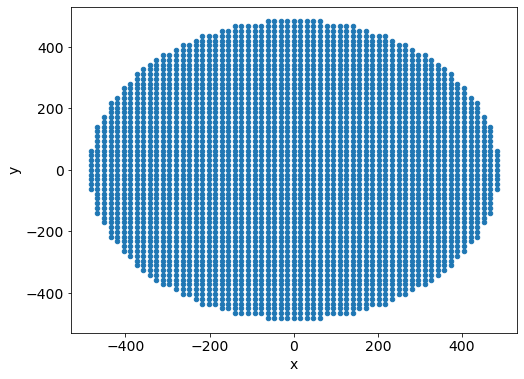

In [65]:
sipm_map.plot(kind='scatter', x='x', y='y')

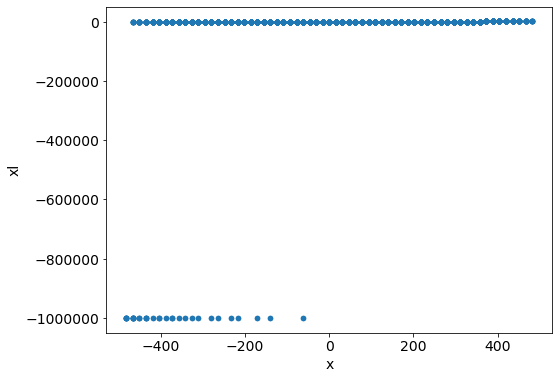

In [66]:
sipm_map.plot(kind='scatter', x='x', y='xl')

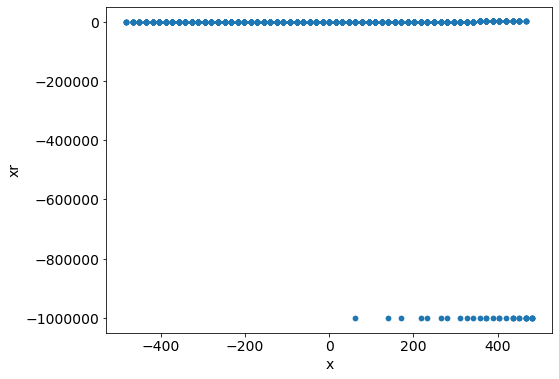

In [67]:
sipm_map.plot(kind='scatter', x='x', y='xr')

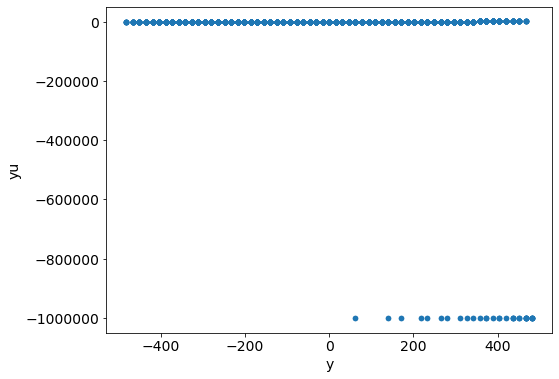

In [68]:
sipm_map.plot(kind='scatter', x='y', y='yu')

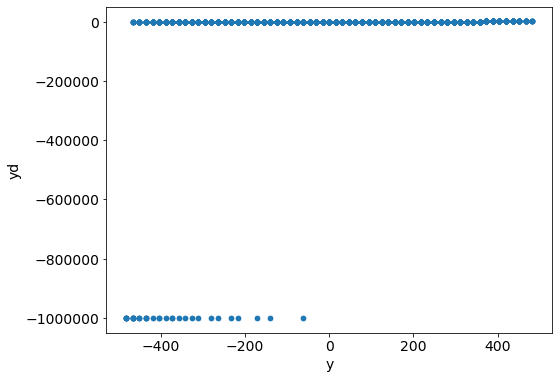

In [69]:
sipm_map.plot(kind='scatter', x='y', y='yd')

In [70]:
sipm_map.to_csv('sipm_map.csv')